Pengelolaan data Installment 

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier

In [2]:
df_install_pay = pd.read_csv("installments_payments.csv")

In [3]:
df_filter_install = df_install_pay[df_install_pay['AMT_INSTALMENT'] != df_install_pay['AMT_PAYMENT']]
df_filter_install = df_filter_install[df_filter_install['DAYS_INSTALMENT'] <= df_filter_install['DAYS_ENTRY_PAYMENT']]

In [4]:
df_filter_install['Filter'] = 'Tolak'

In [5]:
df_filter_install_tolak = df_filter_install[['SK_ID_CURR','Filter']]
df_filter_install_tolak = df_filter_install_tolak.drop_duplicates(subset='SK_ID_CURR', keep='first')

In [6]:
# Periksa apakah terdapat ID yang duplikat
terdapat_duplikat = df_filter_install_tolak['SK_ID_CURR'].duplicated().any()

# Tampilkan hasil
if terdapat_duplikat:
    print("Terdapat ID yang duplikat.")
else:
    print("Tidak terdapat ID yang duplikat.")

Tidak terdapat ID yang duplikat.


Pengelolaan data bureau 

In [7]:
df_bureau = pd.read_csv("bureau.csv")

In [8]:
df_bureau_filter = df_bureau[df_bureau['CREDIT_ACTIVE'] != 'Closed']
df_bureau_filter = df_bureau_filter[df_bureau_filter['CREDIT_DAY_OVERDUE'] >= 7]

In [9]:
df_bureau_filter['Filter'] = 'Tolak'
df_bureau_filter = df_bureau_filter[['SK_ID_CURR','Filter']]
df_bureau_filter = df_bureau_filter.drop_duplicates(subset='SK_ID_CURR', keep='first')

In [10]:
print(df_bureau_filter.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3611 entries, 365 to 1713547
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SK_ID_CURR  3611 non-null   int64 
 1   Filter      3611 non-null   object
dtypes: int64(1), object(1)
memory usage: 84.6+ KB
None


In [11]:
df_train = pd.read_csv("application_train.csv")

In [12]:
#Merge nilai installment
df_train_new = pd.merge(df_train, df_filter_install_tolak, on='SK_ID_CURR', how='left')
#Merge nilai bureau
df_train_new_1 = pd.merge(df_train_new, df_bureau_filter, on='SK_ID_CURR', how='left')
pd.set_option('display.max_column', None)
print(df_train_new_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 124 entries, SK_ID_CURR to Filter_y
dtypes: float64(65), int64(41), object(18)
memory usage: 293.3+ MB
None


In [13]:
# Gabungkan nilai prediksi dari tabel 2 ke tabel 1 jika ID cocok
df_train_new_1['Filter'] = df_train_new_1['Filter_y'].combine_first(df_train_new_1['Filter_x'])

# Hapus kolom prediksi dari tabel 2
df_train_new_1 = df_train_new_1.drop('Filter_y', axis=1)
df_train_new_1 = df_train_new_1.drop('Filter_x', axis=1)

# Tampilkan DataFrame hasil
print(df_train_new_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to Filter
dtypes: float64(65), int64(41), object(17)
memory usage: 290.9+ MB
None


In [14]:
null_counts = df_train_new_1.isnull().sum()
pd.set_option('display.max_rows', None)
print("Jumlah nilai null dalam setiap kolom:")
print(null_counts)

Jumlah nilai null dalam setiap kolom:
SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE           

Pengelolaan data train

In [15]:
# Membuat dictionary pemetaan nilai label ke integer
label_contract_type = {'Consumer loans': 1, 'Cash loans': 2, 'Revolving loans': 3, 'XNA':4}
#label_day = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY':4, 'FRIDAY':5, 'SATURDAY':6, 'SUNDAY':7}
label_Y_N = {'Y':1, 'N':0}
label_yield_group = {'low_normal': 1, 'middle': 2, 'high': 3, 'XNA':4, 'low_action':5}
label_status = {'Approved': 1, 'Canceled': 2, 'Refused': 3, 'Unused offer':4}
label_pay_type = {'Cash through the bank': 1, 'Non-cash from your account': 2, 'Cashless from the account of the employer': 3, 'XNA':4}
label_client_type = {'Repeater': 1, 'New': 2, 'Refreshed': 3, 'XNA':4}
label_porto = {'Cash':1, 'POS':2, 'Cards':3, 'Cards':4, 'Cars':5}
label_type_suite = {'Unaccompanied': 1 ,'Family': 2, 'Spouse, partner': 3, 'Children':4,'Other_A':5 ,'Other_B': 6 
                    ,'Group of people': 7}
label_prod_combo = {'Cash': 1 ,'POS household with interest': 2, 'POS mobile with interest': 3, 'Cash X-Sell: middle':4
                    ,'Cash X-Sell: low':5 ,'Card Street': 6 ,'POS industry with interest': 7, 'POS household without interest': 8
                    ,'Card X-Sell': 9,'Cash Street: high': 10, 'Cash X-Sell: high':11, 'Cash Street: middle':12 
                    ,'Cash Street: low': 13,'POS mobile without interest': 14, 'POS other with interest': 15
                    , 'POS industry without interest': 16, 'POS others without interest':17}
label_purpose = {'XAP': 1 ,'XNA': 2, 'Repairs': 3, 'Repairs':4,'Other':5 ,'Urgent needs': 6 ,'Buying a used car': 7
                 ,'Building a house or an annex': 8,'Medicine': 9,'Payments on other loans': 10, 'Education':11
                 ,'Journey':12,'Purchase of electronic equipment': 13,'Buying a new car': 14, 'Wedding / gift / holiday': 15
                 ,'Buying a home': 16, 'Car repairs':17, 'Furniture':18, 'Buying a holiday home / land':19
                 ,'Business development':20, 'Gasification / water supply':21, 'Buying a garage':22, 'Hobby':23, 'Money for a third person':24, 'Refusal to name the goal':25}
label_type_suite = {'Unaccompanied': 1 ,'Family': 2, 'Spouse, partner': 3, 'Children':4,'Other_A':5 ,'Other_B': 6 
                    ,'Group of people': 7}
label_gender = {'M':1, 'F':2, 'XNA':3}
label_income_type = {'Working': 1 ,'State servant': 2, 'Commercial associate': 3, 'Pensioner':4, 'Unemployed':5 ,'Student': 6 
                    ,'Businessman': 7, 'Maternity leave':8}
label_edu_type = {'Secondary / secondary special': 1 ,'Higher education': 2, 'Incomplete higher': 3, 'Lower secondary':4
                  , 'Academic degree':5}
label_fam_status = {'Single / not married': 1 ,'Married': 2, 'Civil marriage': 3, 'Civil marriage':4 ,'Separated':5, 'Unknown':6}
label_house_type = {'House / apartment': 1 ,'Rented apartment': 2, 'With parents': 3, 'Municipal apartment':4 ,'Office apartment':5, 'Co-op apartment':6}

In [16]:
# Mengganti nilai label string ke int pada kolom
df_train_new_1['NAME_CONTRACT_TYPE'] = df_train_new_1['NAME_CONTRACT_TYPE'].map(label_contract_type)
df_train_new_1['CODE_GENDER'] = df_train_new_1['CODE_GENDER'].map(label_gender)
df_train_new_1['FLAG_OWN_CAR'] = df_train_new_1['FLAG_OWN_CAR'].map(label_Y_N)
df_train_new_1['FLAG_OWN_REALTY'] = df_train_new_1['FLAG_OWN_REALTY'].map(label_Y_N)
df_train_new_1['NAME_TYPE_SUITE'] = df_train_new_1['NAME_TYPE_SUITE'].map(label_type_suite)
df_train_new_1['NAME_INCOME_TYPE'] = df_train_new_1['NAME_INCOME_TYPE'].map(label_income_type)
df_train_new_1['NAME_EDUCATION_TYPE'] = df_train_new_1['NAME_EDUCATION_TYPE'].map(label_edu_type)
df_train_new_1['NAME_FAMILY_STATUS'] = df_train_new_1['NAME_FAMILY_STATUS'].map(label_fam_status)
df_train_new_1['NAME_HOUSING_TYPE'] = df_train_new_1['NAME_HOUSING_TYPE'].map(label_house_type)

In [17]:
# mengisi nilai null tabel df test
df_train_new_1['AMT_ANNUITY'].fillna(df_train_new_1['AMT_ANNUITY'].mean(), inplace=True)
df_train_new_1['AMT_GOODS_PRICE'].fillna(df_train_new_1['AMT_GOODS_PRICE'].mean(), inplace=True)
df_train_new_1['NAME_TYPE_SUITE'].fillna(0, inplace=True)
df_train_new_1['CNT_FAM_MEMBERS'].fillna(0, inplace=True)
df_train_new_1['EXT_SOURCE_1'].fillna(0, inplace=True)
df_train_new_1['EXT_SOURCE_2'].fillna(0, inplace=True)
df_train_new_1['EXT_SOURCE_3'].fillna(0, inplace=True)
df_train_new_1['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df_train_new_1['OBS_30_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_train_new_1['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(df_train_new_1['DEF_30_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_train_new_1['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(df_train_new_1['OBS_60_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_train_new_1['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(df_train_new_1['DEF_60_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_train_new_1['DAYS_LAST_PHONE_CHANGE'].fillna(df_train_new_1['DAYS_LAST_PHONE_CHANGE'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_HOUR'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_DAY'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_WEEK'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_MON'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_MON'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_QRT'].mean(), inplace=True)
df_train_new_1['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(df_train_new_1['AMT_REQ_CREDIT_BUREAU_YEAR'].mean(), inplace=True)
df_train_new_1['NAME_FAMILY_STATUS'].fillna(0, inplace=True)

In [18]:
# mengubah nilai menjadi positif
df_train_new_1['DAYS_BIRTH'] = df_train_new_1['DAYS_BIRTH'].abs()
df_train_new_1['DAYS_EMPLOYED'] = df_train_new_1['DAYS_EMPLOYED'].abs()
df_train_new_1['DAYS_REGISTRATION'] = df_train_new_1['DAYS_REGISTRATION'].abs()
df_train_new_1['DAYS_ID_PUBLISH'] = df_train_new_1['DAYS_ID_PUBLISH'].abs()
df_train_new_1['DAYS_LAST_PHONE_CHANGE'] = df_train_new_1['DAYS_LAST_PHONE_CHANGE'].abs()

In [19]:
# memfilter data
df_train_latest = df_train_new_1.drop(['OWN_CAR_AGE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START'
                            ,'ORGANIZATION_TYPE','APARTMENTS_AVG','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG'
                            ,'YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG'
                            ,'LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG'
                            ,'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE'
                            ,'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE'
                            ,'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE'
                            ,'NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI'
                            ,'YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI'
                            ,'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI'
                            ,'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE'
                            ,'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE','TARGET'],axis=1)

In [20]:
df_train_latest['Filter'].fillna('Terima', inplace=True)

In [21]:
print(df_train_latest['Filter'].value_counts())

Terima    185661
Tolak     121850
Name: Filter, dtype: int64


Proses Data pada Test

In [22]:
df_test = pd.read_csv("application_test.csv")

In [23]:
# Mengganti nilai label string ke int pada kolom
df_test['NAME_CONTRACT_TYPE'] = df_test['NAME_CONTRACT_TYPE'].map(label_contract_type)
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].map(label_gender)
df_test['FLAG_OWN_CAR'] = df_test['FLAG_OWN_CAR'].map(label_Y_N)
df_test['FLAG_OWN_REALTY'] = df_test['FLAG_OWN_REALTY'].map(label_Y_N)
df_test['NAME_TYPE_SUITE'] = df_test['NAME_TYPE_SUITE'].map(label_type_suite)
df_test['NAME_INCOME_TYPE'] = df_test['NAME_INCOME_TYPE'].map(label_income_type)
df_test['NAME_EDUCATION_TYPE'] = df_test['NAME_EDUCATION_TYPE'].map(label_edu_type)
df_test['NAME_FAMILY_STATUS'] = df_test['NAME_FAMILY_STATUS'].map(label_fam_status)
df_test['NAME_HOUSING_TYPE'] = df_test['NAME_HOUSING_TYPE'].map(label_house_type)

In [24]:
# mengisi nilai null tabel df test
df_test['AMT_ANNUITY'].fillna(df_test['AMT_ANNUITY'].mean(), inplace=True)
df_test['AMT_GOODS_PRICE'].fillna(df_test['AMT_GOODS_PRICE'].mean(), inplace=True)
df_test['NAME_TYPE_SUITE'].fillna(0, inplace=True)
df_test['CNT_FAM_MEMBERS'].fillna(0, inplace=True)
df_test['EXT_SOURCE_1'].fillna(0, inplace=True)
df_test['EXT_SOURCE_2'].fillna(0, inplace=True)
df_test['EXT_SOURCE_3'].fillna(0, inplace=True)
df_test['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df_test['OBS_30_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_test['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(df_test['DEF_30_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_test['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(df_test['OBS_60_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(df_test['DEF_60_CNT_SOCIAL_CIRCLE'].mean(), inplace=True)
df_test['DAYS_LAST_PHONE_CHANGE'].fillna(df_test['DAYS_LAST_PHONE_CHANGE'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_HOUR'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_DAY'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_WEEK'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_MON'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_MON'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_QRT'].mean(), inplace=True)
df_test['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(df_test['AMT_REQ_CREDIT_BUREAU_YEAR'].mean(), inplace=True)
df_test['NAME_FAMILY_STATUS'].fillna(0, inplace=True)

In [25]:
# mengubah nilai menjadi positif
df_test['DAYS_BIRTH'] = df_test['DAYS_BIRTH'].abs()
df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].abs()
df_test['DAYS_REGISTRATION'] = df_test['DAYS_REGISTRATION'].abs()
df_test['DAYS_ID_PUBLISH'] = df_test['DAYS_ID_PUBLISH'].abs()
df_test['DAYS_LAST_PHONE_CHANGE'] = df_test['DAYS_LAST_PHONE_CHANGE'].abs()
df_test['REGION_RATING_CLIENT_W_CITY'] = df_test['REGION_RATING_CLIENT_W_CITY'].abs()

In [26]:
# memfilter data
df_test_1 = df_test.drop(['OWN_CAR_AGE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START'
                            ,'ORGANIZATION_TYPE','APARTMENTS_AVG','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG'
                            ,'YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG'
                            ,'LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG'
                            ,'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE'
                            ,'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE'
                            ,'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE'
                            ,'NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI'
                            ,'YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI'
                            ,'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI'
                            ,'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE'
                            ,'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE'],axis=1)

In [27]:
#Merge installment to test
df_test_new_1 = pd.merge(df_test_1, df_filter_install_tolak, on='SK_ID_CURR', how='left')
#Merge bureau to test
df_test_new_1 = pd.merge(df_test_new_1, df_bureau_filter, on='SK_ID_CURR', how='left')

In [28]:
# Gabungkan nilai prediksi dari tabel 2 ke tabel 1 jika ID cocok
df_test_new_1['Filter'] = df_test_new_1['Filter_y'].combine_first(df_test_new_1['Filter_x'])

# Hapus kolom prediksi dari tabel 2
df_test_new_1 = df_test_new_1.drop('Filter_y', axis=1)
df_test_new_1 = df_test_new_1.drop('Filter_x', axis=1)

# Tampilkan DataFrame hasil
#print(df_test_new_1.info())

In [29]:
df_test_new_1['Filter'].fillna('Terima', inplace=True)

In [30]:
#df_test_new_1.info()

In [31]:
#print(df_train_latest['CNT_CHILDREN'].value_counts())

In [32]:
#kolom_negatif = df_test_new_1.select_dtypes(include='number').columns[df_test_new_1.select_dtypes(include='number').lt(0).any()]
#print(kolom_negatif)

Preprocessing Data

In [33]:
#data train setelah filter dan pengolaaan = df_train_latest()
#data test setelah filter dan pengelolaan = df_test_new_1()

df_train_LR = df_train_latest.copy()
df_test_LR = df_test_new_1.copy()

In [34]:
# 2. Preprocessing Data
X_train_LR = df_train_LR.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_train_LR = df_train_LR['Filter']

In [35]:
X_test_LR = df_test_LR.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_test_LR = df_test_LR['Filter']

In [36]:
# 3. Seleksi Fitur
selector = SelectKBest(score_func=chi2, k=69)  # Contoh menggunakan metode chi-square, pilih 5 fitur terbaik
X_train_selected = selector.fit_transform(X_train_LR, y_train_LR)
X_test_selected = selector.fit_transform(X_test_LR, y_test_LR)

In [37]:
# 4. Melatih Model Regresi Logistik
model = LogisticRegression()
model.fit(X_train_selected, y_train_LR)

LogisticRegression()

In [38]:
#5. nilai prediksi test
y_pred_LR = model.predict(X_test_selected)

#6. Evaluasi Model
train_accuracy = model.score(X_train_LR, y_train_LR)
print("Akurasi Pelatihan: {:.2f}%".format(train_accuracy * 100))
y_test_LR = df_test_LR['Filter']
accuracy = accuracy_score(y_test_LR, y_pred_LR)
print("Akurasi Test: {:.2f}%".format(accuracy * 100))

Akurasi Pelatihan: 59.90%
Akurasi Test: 59.36%


In [39]:
#7. nilai prediksi 
df_test_LR['Prediksi'] = y_pred_LR

In [40]:
df_result_LR = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'Prediksi': y_pred_LR})
print(df_result_LR['Prediksi'].value_counts())

Terima    40893
Tolak      7851
Name: Prediksi, dtype: int64


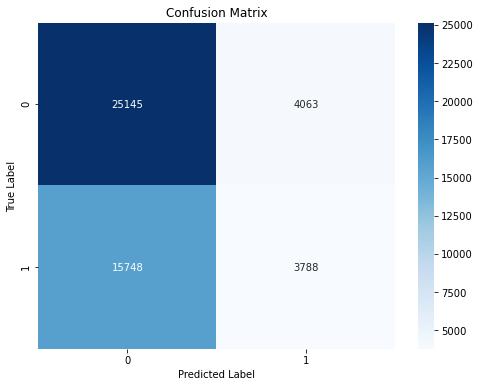

In [41]:
# Hitung confusion matrix
cm = confusion_matrix(y_test_LR, y_pred_LR)

# Visualisasikan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model RF

In [42]:
#data train setelah filter dan pengolaaan = df_train_latest
#data test setelah filter dan pengelolaan = df_test_new_1

df_train_RF = df_train_latest.copy()
df_test_RF = df_test_new_1.copy()

In [43]:
# 2. Preprocessing Data
X_train_RF = df_train_RF.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_train_RF = df_train_RF['Filter']

In [44]:
X_test_RF = df_test_RF.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_test_RF = df_test_RF['Filter']

In [45]:
k = 10  # Jumlah fitur yang akan dipilih
selector = SelectKBest(score_func=f_classif, k=k)

In [46]:
# Skala fitur menggunakan StandardScaler
scaler = StandardScaler()

# Membangun pipeline dengan feature selection dan SVM
rf_model = Pipeline([('selector', selector),
                     ('scaler', scaler),
                     ('random_forest', RandomForestClassifier())])
# Melatih model menggunakan data train
#svm_model.fit(X_train, y_train)

# Melatih model dengan tqdm
for _ in tqdm(range(1)):
    rf_model.fit(X_train_RF, y_train_RF)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.94s/it]


In [47]:
# Membuat prediksi pada data test
y_pred_RF = rf_model.predict(X_test_RF)

# Evaluasi model
accuracy_RF = rf_model.score(X_test_RF, y_test_RF)
#6. Evaluasi Model
accuracy_RF_train = model.score(X_train_RF, y_train_RF)
print("Akurasi Pelatihan: {:.2f}%".format(accuracy_RF_train * 100))
y_test_RF = df_test_RF['Filter']
accuracy_RF = accuracy_score(y_test_RF, y_pred_RF)
print("Akurasi Test: {:.2f}%".format(accuracy_RF * 100))

Akurasi Pelatihan: 59.90%
Akurasi Test: 57.30%


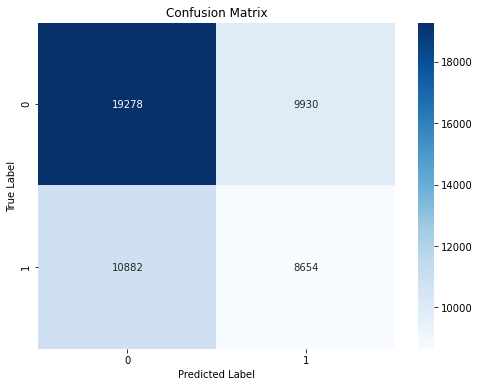

In [48]:
# Hitung confusion matrix
cm = confusion_matrix(y_test_RF, y_pred_RF)

# Visualisasikan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model MLP

In [49]:
#data train setelah filter dan pengolaaan = df_train_latest
#data test setelah filter dan pengelolaan = df_test_new_1

df_train_MLP = df_train_latest.copy()
df_test_MLP = df_test_new_1.copy()

In [50]:
# 2. Preprocessing Data
X_train_MLP = df_train_MLP.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_train_MLP = df_train_MLP['Filter']

In [51]:
X_test_MLP = df_test_MLP.drop('Filter', axis=1)  # Matriks fitur (atribut)
y_test_MLP = df_test_MLP['Filter']

In [52]:
# Pemilihan fitur dengan SelectKBest
k = 7  # Jumlah fitur yang ingin dipilih
selector_MLP = SelectKBest(f_classif, k=k)
selector_MLP.fit(X_train_MLP, y_train_MLP)

# Mengambil fitur terpilih dari data train dan test
X_train_selected_MLP = selector_MLP.transform(X_train_MLP)
X_test_selected_MLP = selector_MLP.transform(X_test_MLP)

# Membuat model MLP
model_MLP = MLPClassifier()

# Melatih model dengan data train yang telah dipilih fiturnya
model_MLP.fit(X_train_selected_MLP, y_train_MLP)

# Memprediksi nilai target untuk data train dan test
y_train_pred_MLP = model_MLP.predict(X_train_selected_MLP)
y_test_pred_MLP = model_MLP.predict(X_test_selected_MLP)

# Menghitung dan menampilkan akurasi pelatihan
train_accuracy_MLP = accuracy_score(y_train_MLP, y_train_pred_MLP)
print("Akurasi Pelatihan: {:.2f}%".format(train_accuracy_MLP * 100))

# Menghitung dan menampilkan akurasi pengujian
test_accuracy_MLP = accuracy_score(y_test_MLP, y_test_pred_MLP)
print("Akurasi Pelatihan: {:.2f}%".format(test_accuracy_MLP * 100))


Akurasi Pelatihan: 62.54%
Akurasi Pelatihan: 60.29%


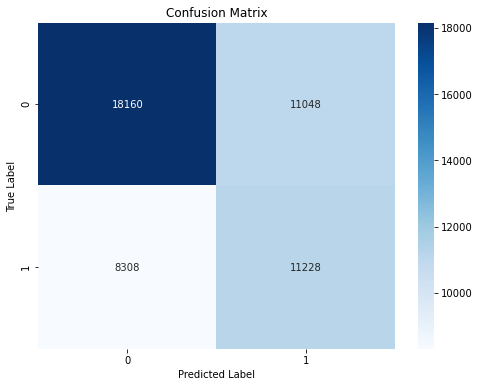

In [53]:
# Hitung confusion matrix
cm = confusion_matrix(y_test_MLP, y_test_pred_MLP)

# Visualisasikan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [54]:
#X_train_RF.info()

In [55]:
#df_test_new_1.info()